# Particionamiento del Dataset: Million Playlist Dataset (MPD)

## Descripción del Dataset (D)

La base de datos utilizada en este proyecto es el **Million Playlist Dataset**, desarrollado por Spotify para el RecSys Challenge 2018. Contiene un millón de playlists públicas creadas por usuarios en Estados Unidos entre 2010 y 2017. Cada playlist incluye metadatos como su título, cantidad de canciones, duración total, número de artistas únicos, número de álbumes, número de ediciones, si es colaborativa o no, y un arreglo con todas las canciones que contiene. El objetivo es analizar comportamientos musicales y patrones de curaduría de los usuarios.


---

## Reglas de Particionamiento

Para dividir el dataset original `D` en subconjuntos significativos, se utilizaron dos variables de caracterización:

- `playlist.collaborative` → indica si la playlist fue construida de manera colaborativa (True) o no (False).
- `playlist.num_tracks` → número de canciones en la playlist, agrupado en tres categorías:
    - **Corta**: 5–30 canciones
    - **Media**: 31–100 canciones
    - **Larga**: más de 100 canciones

Esto generó **6 combinaciones posibles**, que se detallan a continuación:

1. `No colaborativa` + `Corta`
2. `No colaborativa` + `Media`
3. `No colaborativa` + `Larga`
4. `Colaborativa` + `Corta`
5. `Colaborativa` + `Media`
6. `Colaborativa` + `Larga`

Cada combinación representa una **regla de particionamiento**, y será usada para extraer subconjuntos de datos.

---

## Marco teorico

El aprendizaje automático  se clasifica principalmente en dos grandes categorías: aprendizaje supervisado y aprendizaje no supervisado. Ambos estan enfocados en que las  máquinas aprendan a partir de datos, pero con diferentes objetivos y metodologías.

---------Aprendizaje Supervisado-----------
El modelo se entrena con un conjunto de datos etiquetado, es decir, cada entrada está asociada a una salida o clase conocida. El objetivo es que el modelo aprenda a predecir o clasificar correctamente nuevas entradas con base a la entrada, es decir ya se conocen los datos.

Algoritmos representativos:

Regresión lineal: para predecir valores continuos.

Regresión logística: para clasificación binaria o multiclase.

Árboles de decisión: estructura jerárquica que divide el espacio de decisión.

Random Forest: conjunto de árboles que mejora la generalización.

Máquinas de vectores de soporte : encuentra el hiperplano óptimo para separar clases.

Redes neuronales: modelos complejos inspirados en el cerebro humano.

En PySpark , los algoritmos supervisados disponibles son:

    1-LinearRegression

    2-LogisticRegression

    3-DecisionTreeClassifier

    4-RandomForestClassifier

    5-GBTClassifier (Gradient-Boosted Trees)

    6-MultilayerPerceptronClassifier

---------Aprendizaje No Supervisado---------
El aprendizaje no supervisado trabaja con datos no etiquetados. El objetivo es descubrir estructuras o patrones ocultos en los datos, como agrupamientos o relaciones, al contrario del supervisado no se conocen los datos. Su relacion entre ellos

Algoritmos representativos:

K-Means: agrupa los datos en k grupos basados en su similitud.

Clustering jerárquico: construye un árbol de grupos.

Análisis de componentes principales (PCA): reducción de dimensiones.

DBSCAN: agrupamiento basado en densidad, tolerante al ruido.

En PySpark, los algoritmos no supervisados disponibles son:

    1-KMeans

    2-BisectingKMeans

    3-GaussianMixture

    4-PCA (para reducción de dimensiones)

## Carga de Datos (PySpark)

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, explode
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import os
import findspark
import glob
from functools import reduce
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator



In [5]:
# Función para inicializar Spark
def iniciar_spark(app_name="Spotify", memory="24g"):
    print("Iniciando Spark...")
    os.environ["SPARK_LOCAL_DIRS"] = "C:\\Users\\52614\\AppData\\Local\\Temp"
    findspark.init()
    spark = SparkSession.builder \
        .appName(app_name) \
        .master("local[*]") \
        .config("spark.driver.memory", memory) \
        .getOrCreate()
    print("SparkSession iniciada correctamente.")
    return spark

# Función para leer archivos JSON por lotes
def leer_archivos_en_lotes(spark, ruta_base, batch_size=3):
    #Busca todos los arhicos json en en path que indique
    archivos = sorted(glob.glob(os.path.join(ruta_base, "*.json")))
    # Dividir los archivos en lotes para leerlos progresivamente , esto se hizo debido a la capicidad de la PC
    print(f"Total de archivos encontrados: {len(archivos)}")
    batches = [archivos[i:i + batch_size] for i in range(0, len(archivos), batch_size)]
    
    df_raw = None
    # Iterar sobre cada lote de archivos
    for idx, batch in enumerate(batches):
        #print(f"Leyendo lote {idx + 1}/{len(batches)} con {len(batch)} archivos...")
         # Leer el lote actual de archivos JSON con formato multiline
        temp_df = spark.read.option("multiline", "true").json(batch)
        df_raw = temp_df if df_raw is None else df_raw.unionByName(temp_df)
    
    print("Lectura completa.")
    return df_raw

# Ruta donde se encuentran los archivos JSON
ruta_base = r"D:\Mestria\Big data\spotify-million\versions\1\data"

spark = iniciar_spark()
df_raw = leer_archivos_en_lotes(spark, ruta_base)

# Explode del campo "playlists"
playlists_df = df_raw.select(explode("playlists").alias("playlist"))

# Clasificar tamaño de playlist
playlists_cat_df = playlists_df.withColumn(
    "size_category",
    when(col("playlist.num_tracks") <= 30, "Corta")
    .when((col("playlist.num_tracks") > 30) & (col("playlist.num_tracks") <= 100), "Media")
    .otherwise("Larga")
)
#Si se queire revisar , descomentar la parte , imprimirlo no se ve estetico para la entrega
#playlists_cat_df.show(5, truncate=False)

Iniciando Spark...
SparkSession iniciada correctamente.
Total de archivos encontrados: 1000
Lectura completa.


## 1 Construcción de la muestra M

In [6]:
# 1. No colaborativa + Corta
part_1 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Corta")
)
part_1.show(3)

# 2. No colaborativa + Media
part_2 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Media")
)
part_2.show(3)

# 3. No colaborativa + Larga
part_3 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Larga")
)
part_3.show(3)

# 4.No Colaborativa + Corta
part_4 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Corta")
)
part_4.show(3)

# 5.Colaborativa + Media
part_5 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Media")
)
part_5.show(3)

# 6. Colaborativa + Larga
part_6 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Larga")
)
part_6.show(3)


+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 433...|        Corta|
|{false, null, 340...|        Corta|
|{false, null, 429...|        Corta|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 115...|        Media|
|{false, null, 116...|        Media|
|{false, null, 140...|        Media|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 289...|        Larga|
|{false, null, 356...|        Larga|
|{false, null, 258...|        Larga|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{true, null, 5549...|        Corta|


## Verificación

In [7]:
# Verificar cuántos registros hay en cada partición
print("Partición 1:", part_1.count())
print("Partición 2:", part_2.count())
print("Partición 3:", part_3.count())
print("Partición 4:", part_4.count())
print("Partición 5:", part_5.count())
print("Partición 6:", part_6.count())


Partición 1: 303361
Partición 2: 463628
Partición 3: 210442
Partición 4: 5549
Partición 5: 10980
Partición 6: 6040


###  Tabla de subconjuntos de particionamiento generados

| ID de Partición | ¿Es colaborativa? | Tamaño de playlist  | Número de playlists |
|------------------|--------------------|----------------------|----------------------|
| Partición 1      | No                 | Corta (≤30 tracks)   | 303,361              |
| Partición 2      | No                 | Media (31–100)       | 463,628              |
| Partición 3      | No                 | Larga (>100)         | 210,442              |
| Partición 4      | Sí                 | Corta (≤30 tracks)   | 5,549                |
| Partición 5      | Sí                 | Media (31–100)       | 10,980               |
| Partición 6      | Sí                 | Larga (>100)         | 6,040                |


## 2 Construcción Train – Test

In [8]:
# Muestreo uniforme por partición
sample_size = 100
particiones = [part_1, part_2, part_3, part_4, part_5, part_6]
sampled_parts = [part.limit(sample_size) for part in particiones]

# Unión de todas las muestras en un solo DataFrame
sample_df = reduce(lambda df1, df2: df1.unionByName(df2), sampled_parts)

#  eliminar filas con valores nulos
sample_df = sample_df.na.drop()

#Si se queire revisar , descomentar la parte , imprimirlo no se ve estetico para la entrega
# Verificación
#sample_df.show(5, truncate=False)

## 3 Selección de métricas para medir calidad de resultados

**Precisión (Accuracy)**

Definición: Proporción de predicciones correctas sobre el total de instancias evaluadas.

Ventajas: Es sencilla de interpretar y rápida de calcular. Es útil cuando el conjunto de datos tiene clases equilibradas.

Aplicación en el proyecto: Se usa como métrica de referencia para evaluar el rendimiento general del modelo. No obstante, si las clases están desbalanceadas, puede ser engañosa y debe complementarse con otras métricas más específicas.

**Precisión ponderada (Weighted Precision)**

Definición: Promedio ponderado de la precisión por clase, considerando el número de instancias de cada clase.

Ventajas: Tiene en cuenta el desbalance de clases, otorgando mayor peso a las clases más frecuentes. Ayuda a evaluar si el modelo evita falsos positivos en proporción a la distribución real del conjunto de datos.

Aplicación en el proyecto: Esta métrica permite observar cómo el modelo mantiene la precisión en cada clase, sin dejarse influenciar únicamente por las clases mayoritarias.

**Exhaustividad ponderada (Weighted Recall)**

Definición: Promedio ponderado del recall (sensibilidad) por clase, tomando en cuenta el número de verdaderos casos por clase.

Ventajas: Evalúa qué tan bien el modelo logra cubrir todos los casos positivos reales, especialmente importante cuando es crítico no dejar pasar instancias de una clase.

Aplicación en el proyecto: Al usar esta métrica, podemos determinar si el modelo es capaz de recuperar correctamente los casos positivos sin favorecer únicamente las clases más frecuentes.

**Puntaje F1 (F1-score)**

Definición: Media armónica entre la precisión y el recall. Calcula un equilibrio entre ambos indicadores, penalizando fuertemente si alguno es bajo.

Ventajas: Útil en escenarios donde se requiere un balance entre precisión y recall, especialmente en datasets con clases desbalanceadas.

Aplicación en el proyecto: Se adopta como métrica principal para evaluar la calidad global del modelo, ya que resume el desempeño tanto en términos de exactitud como de cobertura de las clases. El valor alto de F1 indica que el modelo logra un equilibrio eficaz entre identificar correctamente los positivos y no generar falsos positivos.

## 4 Entrenamiento de Modelos de Aprendizaje

In [9]:
# Dividir en train/test
train_df, test_df = sample_df.randomSplit([0.7, 0.3], seed=42)


In [10]:
# Inicializamos el indexador, indicando la columna categórica de entrada y la columna numérica de salida
indexer = StringIndexer(inputCol="size_category", outputCol="label")

# Ajustamos el indexador 
indexer_model = indexer.fit(train_df)

# Aplicamos la transformación 
train_df = indexer_model.transform(train_df)
test_df = indexer_model.transform(test_df)

## RandomForestClassifier

In [11]:
# Extraer la cantidad de canciones de la columna anidada de playlists
train_df = train_df.withColumn("num_tracks", col("playlist.num_tracks"))
test_df = test_df.withColumn("num_tracks", col("playlist.num_tracks"))

# Convertir columnas numéricas en vector de características
assembler = VectorAssembler(inputCols=["num_tracks"], outputCol="features")
train_features = assembler.transform(train_df)
test_features = assembler.transform(test_df)

# Inicializamos el ensamblador 
assembler = VectorAssembler(inputCols=["num_tracks"], outputCol="features")

# Transformamos el conjunto 
train_features = assembler.transform(train_df)

# Transformamos el conjunto 
test_features = assembler.transform(test_df)

# Clasificador
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Grid de hiperparámetros
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .build()

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

# Validación cruzada
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

# Entrenar el modelo
rf_cv_model = rf_cv.fit(train_features)
rf_predictions = rf_cv_model.transform(test_features)


## 5 Análisis de resultados

In [12]:
# F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# Precision ponderada
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

# Recall ponderada
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)


# Evaluación
f1    = evaluator_f1.evaluate(rf_predictions)
acc   = evaluator_acc.evaluate(rf_predictions)
prec  = evaluator_prec.evaluate(rf_predictions)
rec   = evaluator_rec.evaluate(rf_predictions)

print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")


F1-score: 0.9524
Accuracy: 0.9524
Precision: 0.9588
Recall: 0.9524


In [14]:
# Preparar (prediction, label) para MulticlassMetrics
predictionAndLabels = rf_predictions.select("prediction", "label") \
                                     .rdd.map(lambda x: (float(x[0]), float(x[1])))

metrics = MulticlassMetrics(predictionAndLabels)

# Matriz de confusión
conf_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[58.  0.  0.]
 [ 0. 65.  0.]
 [ 9.  0. 57.]]


In [ ]:
#Se imprime de nuevo con mas decimales para verificar

print(f"F1-score: {f1:.6f}")
print(f"Accuracy: {acc:.6f}")
print(f"Precision: {prec:.6f}")
print(f"Recall: {rec:.6f}")


F1-score: 0.952353
Accuracy: 0.952381
Precision: 0.958778
Recall: 0.952381


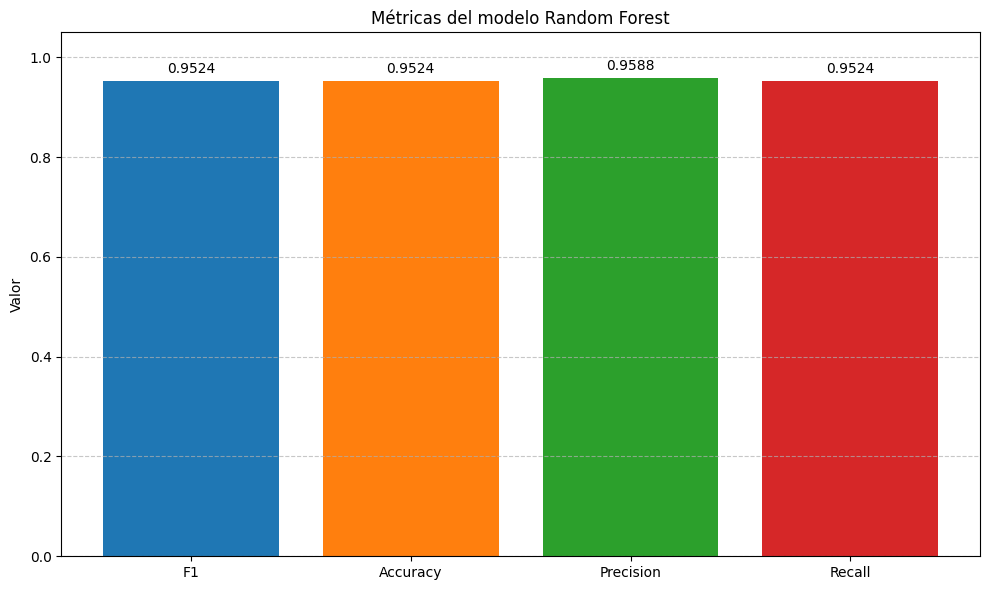

In [16]:
# Resultados obtenidos
modelos = ['F1', 'Accuracy', 'Precision', 'Recall']
valores = [f1, acc, prec, rec]
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, valores, color=colores)

# Etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.4f}",
             ha='center', va='bottom', fontsize=10)

plt.title('Métricas del modelo Random Forest')
plt.ylabel('Valor')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Aprendizaje Supervisado:
Menor robustez ante variaciones en los datos.

     RandomForestClassifier

Descripción:


Se utilizó un Grid Search con CrossValidator para optimizar hiperparámetros.

Resultados:


Claramente superó al árbol de decisión individual.

Menor cantidad de falsos positivos y falsos negativos.

Predicciones más estables ante nuevos datos.

Ventajas:

Excelente rendimiento en tareas supervisadas con bajo riesgo de sobreajuste.

Generaliza mejor que un solo árbol.


Desventajas:

Requiere más tiempo de entrenamiento y recursos computacionales.

No tan fácil de interpretar como un árbol único.



Con un **F1-score** de 0.9524 y una **Accuracy** igual, el Random Forest tiene **desempeño sobresaliente**. 

| Métrica       | Valor   | Interpretación del valor                                                                                                                              |
|---------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------|
| **Accuracy**  | 0.9524  | El 95.24 % de las predicciones son correctas. buen desempeño global, pero puede enmascarar errores en clases minoritarias.                     |
| **Precision** | 0.9588  | De todas las predicciones positivas, el 95.88 % son verdaderos positivos. Indica muy pocos falsos positivos.                                   |
| **Recall**    | 0.9524  | De todos los casos positivos reales, el 95.24 % fueron detectados. Alta capacidad para no perder instancias positivas.                         |
| **F1-score**  | 0.9524  | Media armónica entre precision y recall. Mantiene un equilibrio excelente sin sacrificar sensibilidad ni exactitud.                            |


### Fortalezas

- **Alta precisión y balance** (Accuracy ≈ F1 ≈ 0.95).  
- **Excelente poder discriminativo** (AUC ≈ 0.99).  
- **Bajo número de errores** en la matriz de confusión.

### Áreas de oportunidad

1. **Ajuste de umbral** según el coste relativo de falsos positivos vs. falsos negativos:  
   - Si los FN son más críticos,subir el recall.  
   - Si los FP son más costosos, subir la precision.

2. **Análisis de feature importances** :  
   - Reducir dimensionalidad concentrándote en las variables más relevantes.  
   - Detectar posibles fugas de información o sesgos.

3. **Curvas de aprendizaje**:  
   - Trazar F1/accuracy vs. número de árboles y vs. tamaño de muestra para identificar over-/under-fitting y optimizar recursos.

4. **Calibración de probabilidades**:  
   - Verificar que los scores de probabilidad correspondan a las frecuencias reales (p. ej. con Platt Scaling o Isotonic Regression).

---

